Import packages

In [11]:
import io
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.cloud import vision

Authenticate Google Cloud

In [2]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'client_file_vision_ai_demo.json'
client = vision.ImageAnnotatorClient()

DefaultCredentialsError: File client_file_vision_ai_demo.json was not found.

Define the image file

In [95]:
image_path = '/Users/michaelgiordano/Documents/Research/Leander_Heldring/OCR_Improvements/google_vision_ai_demo/images/1888_Page_161.png'
cvimage = cv2.imread(image_path)
_, encoded_image = cv2.imencode('.png', cvimage)
api_image = vision.Image(content=encoded_image.tobytes())
response = client.text_detection(image = api_image)
texts = response.text_annotations

for text in texts:
    # print (text.description)
    vertices = np.array(
        [(vertex.x, vertex.y) 
             for vertex in text.bounding_poly.vertices
        ])
    # We are using cv2 rectnagle method to draw bounding boxes
    # that requires 2 points on the image to draw the box
    # The top,left co-ordinates and bottom,right co-ordindates of the box
    # We can get those using the code below. 
    xmin, xmax = min(vertices[:, 0]), max(vertices[:, 0])
    ymin, ymax = min(vertices[:, 1]), max(vertices[:, 1])
    
    cv2.rectangle(cvimage, (xmin, ymin), (xmax, ymax), (0, 255, 0), 1)

if response.error.message:
    print(response.error.message)

plt.figure(figsize=(20, 40))
plt.imshow(cvimage)

NameError: name 'client' is not defined

In [96]:
with io.open(image_path, 'rb') as image_file:
    content = image_file.read()
image = vision.Image(content=content)

Get the response back from Cloud Vision

In [ ]:
response = client.text_detection(image=image)
print(response)

This is my attempt at trying to extract specific information from Cloud Vision's response

In [ ]:
for text in response.text_annotations:
    print(text.bounding_poly)
    print(text.score)
    print(text.description)

# Below here I am making attempts at image pre-processing

In [161]:
#Import the image, define it as "cvimage"

image_path = '/Users/michaelgiordano/Documents/Research/Leander_Heldring/OCR_Improvements/google_vision_ai_demo/images/1888_Page_161.png'
cvimage = cv2.imread(image_path)

In [162]:
#Define a function that allows us to display the original image

#https://stackoverflow.com/questions/28816046/
#displaying-different-images-with-actual-size-in-matplotlib-subplot
def display(im_path):
    dpi = 300
    im_data = plt.imread(im_path)

    height, width  = im_data.shape[:2]
    
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

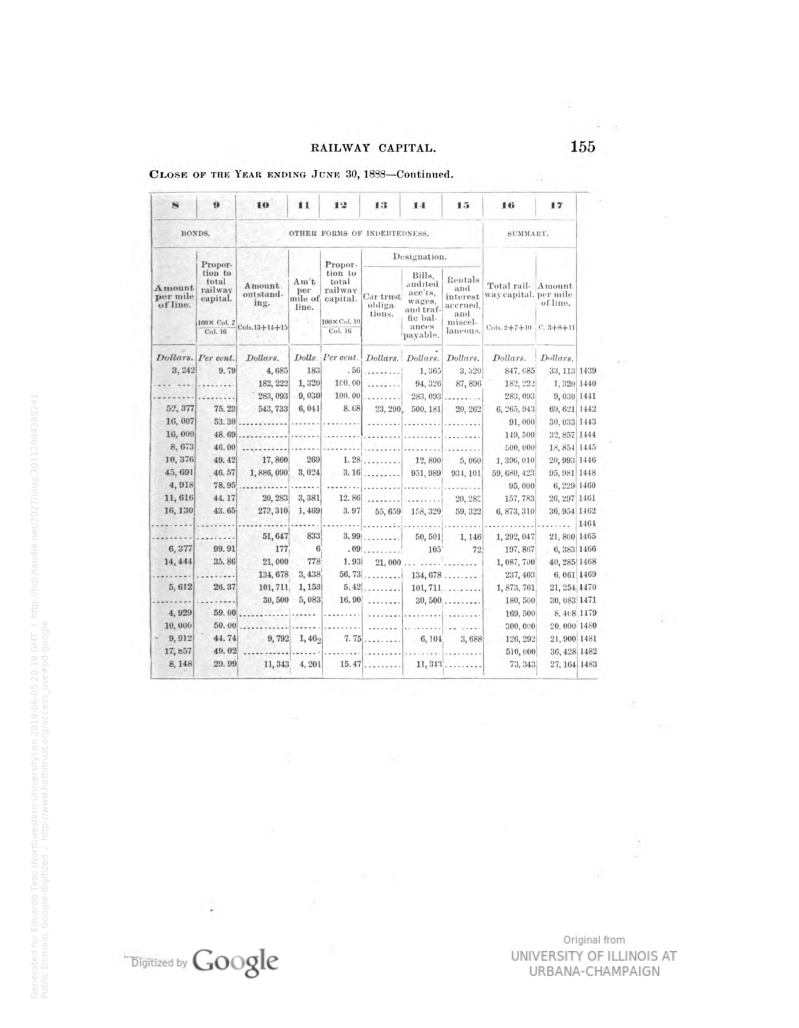

In [163]:
#Now display the original image
display(image_path)

Define a program to remove the borders

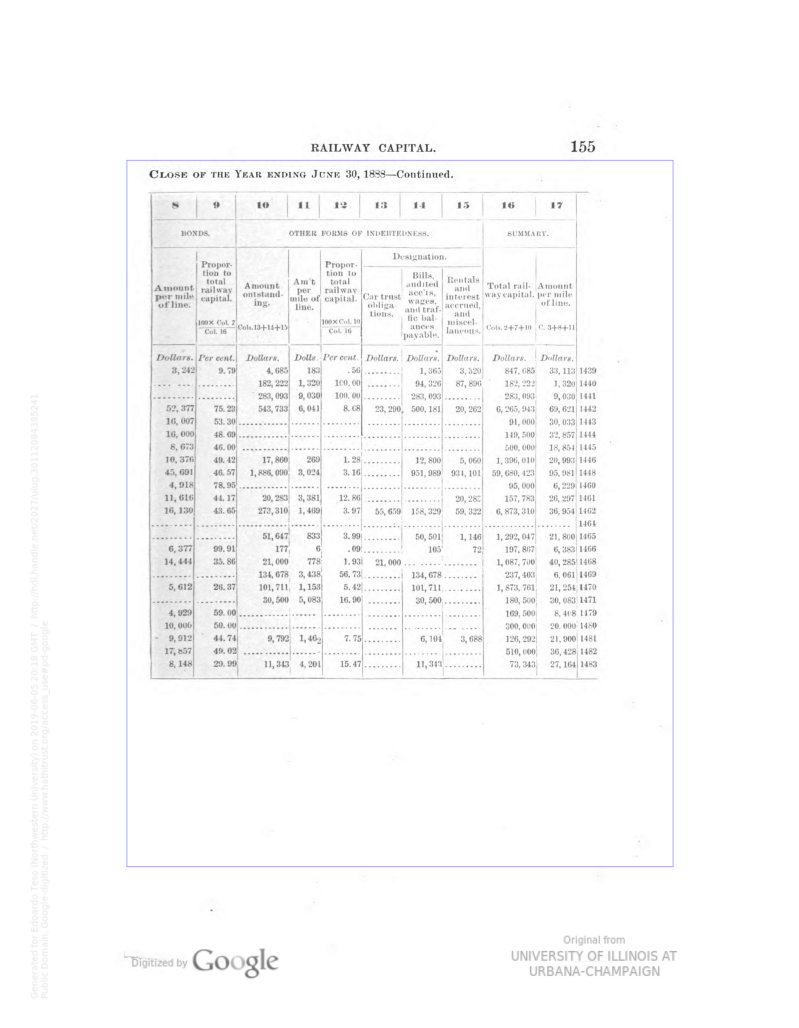

In [164]:
#Load the image file to define the height and width of the scan

height, width = cvimage.shape[0:2]

#Define the page edges
LeftSide = int(0)
RightSide = int(width)
TopSide = int(0)
BottomSide = int(height)

#Roughly define the margins
LeftMargin = int(width*.15)
RightMargin = int(width*.85)
TopMargin = int(height*.15)
BottomMargin = int(height*.85)

#Check the margins are good by drawing lines to show outside portion

#First define a new name for the image so you don't mess up later processing

MarginTest = cv2.imread(image_path)

#Top margin
cv2.line(MarginTest,(LeftMargin,TopMargin),(RightMargin,TopMargin),(255,0,0),1)
#Left margin
cv2.line(MarginTest,(LeftMargin,TopMargin),(LeftMargin,BottomMargin),(255,0,0),1)
#Bottom margin
cv2.line(MarginTest,(LeftMargin,BottomMargin),(RightMargin,BottomMargin),(255,0,0),1)
#Right margin
cv2.line(MarginTest,(RightMargin,TopMargin),(RightMargin,BottomMargin),(255,0,0),1)

#Save and display the output

cv2.imwrite('/Users/michaelgiordano/Documents/Research/Leander_Heldring/OCR_Improvements/google_vision_ai_demo/images/1888_Page_161margintest.png', MarginTest) 

display('/Users/michaelgiordano/Documents/Research/Leander_Heldring/OCR_Improvements/google_vision_ai_demo/images/1888_Page_161margintest.png')


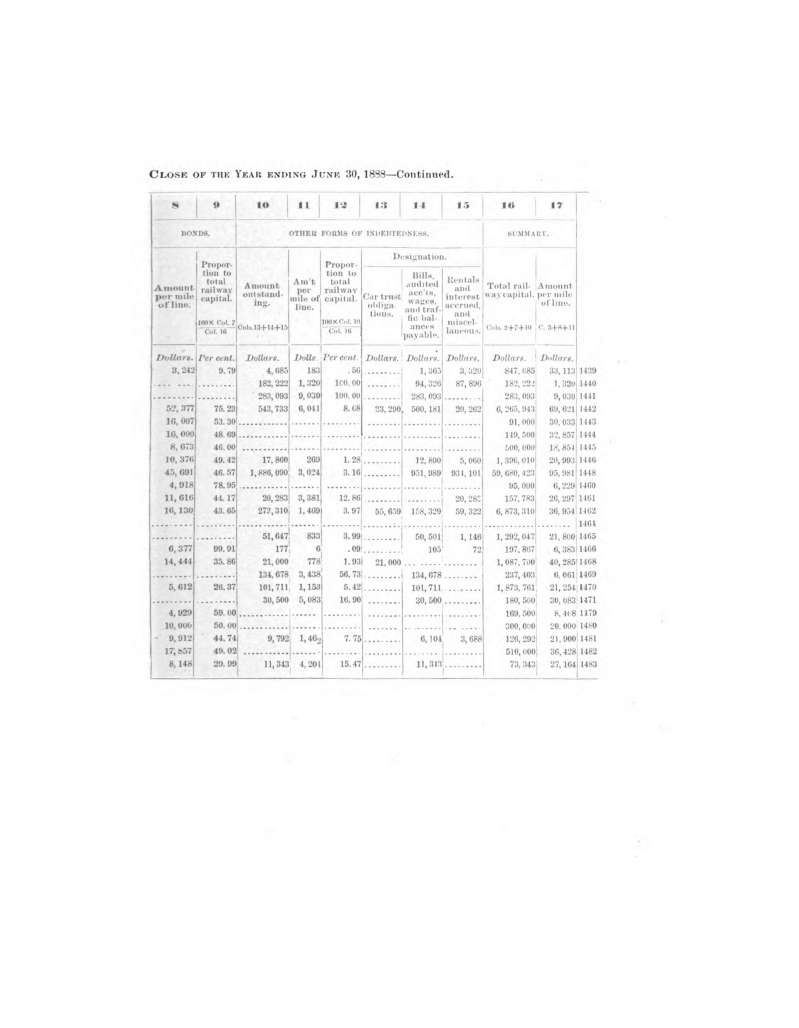

In [165]:
#Insert the desired color for the rectangle you are covering the margins with
White = (255,255,255)

#Define a rectangle for the portion outside of the bottom margin
BLMargin = (LeftSide,BottomMargin)
BRCorner = (RightSide, BottomSide)

#White out the portion outside of the bottom margin
cvimage = cv2.rectangle(cvimage, BLMargin, BRCorner, White, -1)

#Define top left margin point, combine with BLMargin for the portion outside of the left margin
TLMargin = (LeftMargin,TopSide)

#White out the portion outside of the left margin
cvimage = cv2.rectangle(cvimage, TLMargin, BLMargin, White, -1)

#Define top right corner point, combine with TLMargin for the portion outside of the top margin
TRCorner = (RightSide,TopMargin)

#White out the portion outside of the top margin
cvimage = cv2.rectangle(cvimage, TLMargin, TRCorner, White, -1)

#Define bottom right margin point, combine with TRCorner for the portion outside of the right margin
BRMargin = (RightMargin,BottomSide)

#White out the portion outside of the top margin
cvimage = cv2.rectangle(cvimage, BRMargin, TRCorner, White, -1)

cv2.imwrite('/Users/michaelgiordano/Documents/Research/Leander_Heldring/OCR_Improvements/google_vision_ai_demo/images/1888_Page_161close.png', cvimage) 

display('/Users/michaelgiordano/Documents/Research/Leander_Heldring/OCR_Improvements/google_vision_ai_demo/images/1888_Page_161close.png')

# This next part is an attempt at my original processing idea. First, identify and extend the vertical lines for the table, then perform the actions of drawing the margin box and clearing outside of the margin box

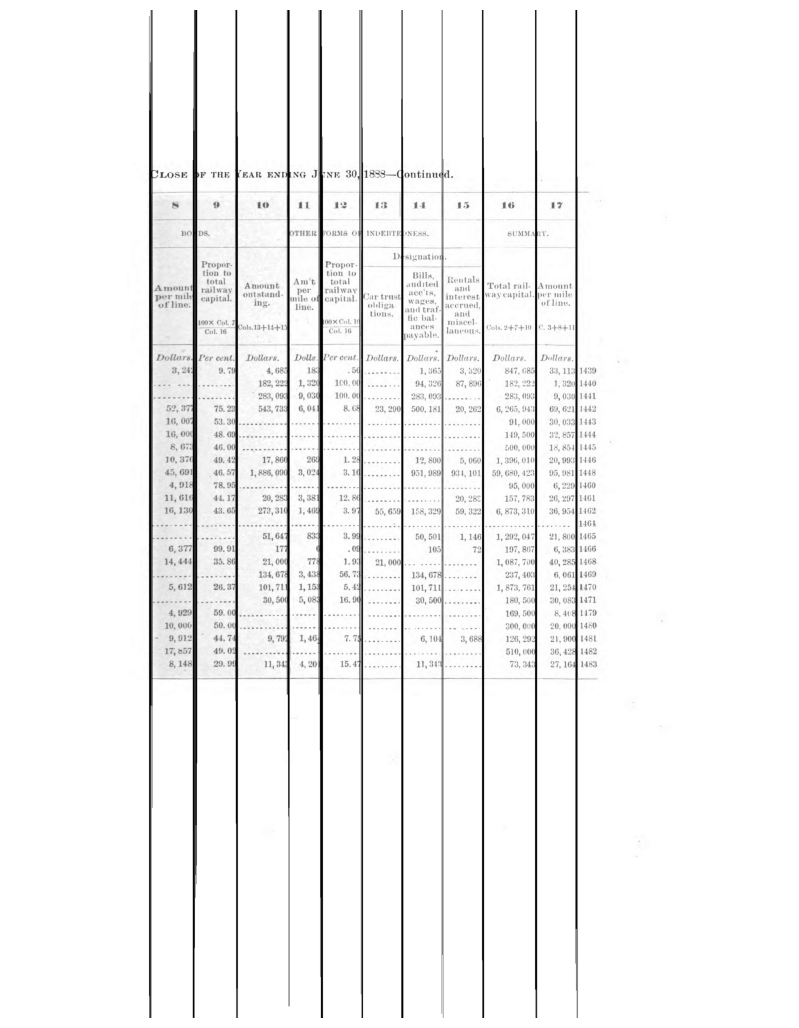

In [166]:
#Bold the vertical lines


edges = cv2.Canny(cvimage,50,150,apertureSize = 3)

    
minLineLength = 100
maxLineGap = 50
lines = cv2.HoughLinesP(edges,1,np.pi/1,50,minLineLength,maxLineGap)
    
#if lines is None: 
#    continue
    
for x in range(0, len(lines)):
        for x1,y1,x2,y2 in lines[x]:
            cv2.line(cvimage,(x1,y1-1500),(x2,y2+1500),(0,0,0),1)
            
cv2.imwrite('/Users/michaelgiordano/Documents/Research/Leander_Heldring/OCR_Improvements/google_vision_ai_demo/images/1888_Page_161vlines.png', cvimage) 

display('/Users/michaelgiordano/Documents/Research/Leander_Heldring/OCR_Improvements/google_vision_ai_demo/images/1888_Page_161vlines.png')

In [167]:
#Draw the margin box

#Top margin
cv2.line(cvimage,(LeftMargin,TopMargin),(RightMargin,TopMargin),(0,0,0),3)
#Left margin
cv2.line(cvimage,(LeftMargin,TopMargin),(LeftMargin,BottomMargin),(0,0,0),3)
#Bottom margin
cv2.line(cvimage,(LeftMargin,BottomMargin),(RightMargin,BottomMargin),(0,0,0),3)
#Right margin
cv2.line(cvimage,(RightMargin,TopMargin),(RightMargin,BottomMargin),(0,0,0),3)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

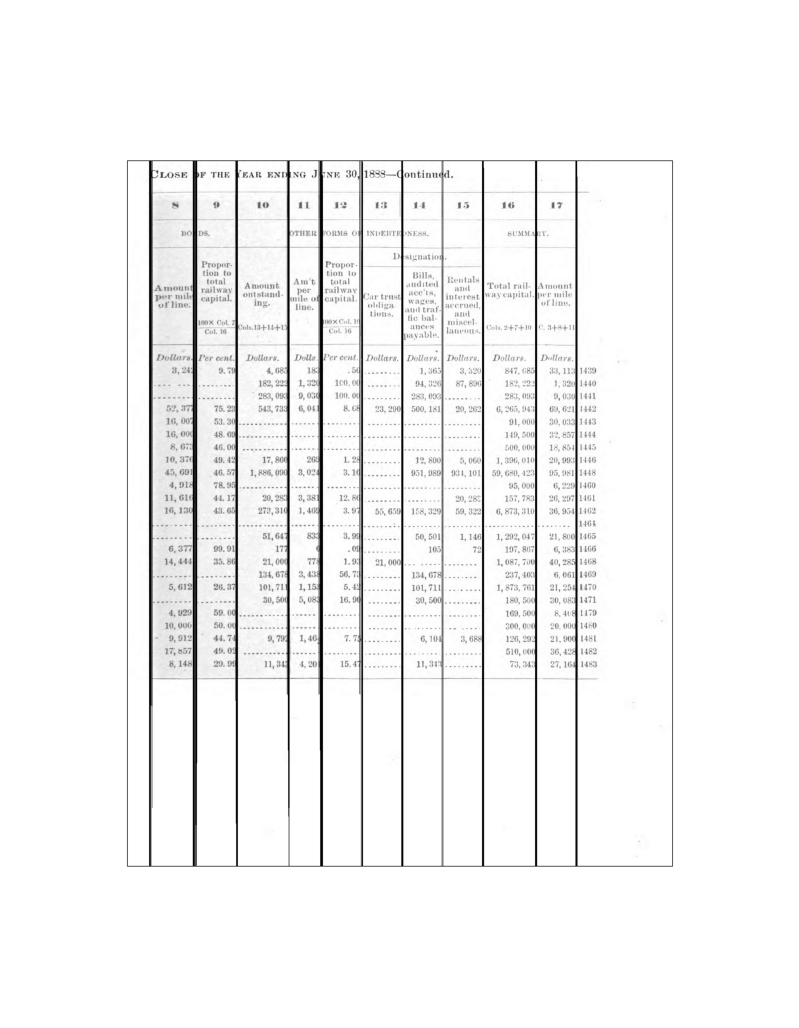

In [168]:

#White out the portion outside of the bottom margin
cvimage = cv2.rectangle(cvimage, BLMargin, BRCorner, White, -1)

#White out the portion outside of the left margin
cvimage = cv2.rectangle(cvimage, TLMargin, BLMargin, White, -1)

#White out the portion outside of the top margin
cvimage = cv2.rectangle(cvimage, TLMargin, TRCorner, White, -1)

#White out the portion outside of the top margin
cvimage = cv2.rectangle(cvimage, BRMargin, TRCorner, White, -1)

cv2.imwrite('/Users/michaelgiordano/Documents/Research/Leander_Heldring/OCR_Improvements/google_vision_ai_demo/images/1888_Page_161vlineclose.png', cvimage) 

display('/Users/michaelgiordano/Documents/Research/Leander_Heldring/OCR_Improvements/google_vision_ai_demo/images/1888_Page_161vlineclose.png')